# iMPLEMENTATION AVEC VISUAL TAXIS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

from gymnasium.utils.env_checker import check_env
import dm_control.mjcf as mjcf
from gymnasium import spaces

import pickle

from flygym import Fly, Camera
from flygym.arena import FlatTerrain
from flygym.examples.obstacle_arena import ObstacleOdorArena
from flygym.examples.turning_controller import HybridTurningNMF
from flygym.arena import BaseArena
from flygym.vision.visualize import save_video_with_vision_insets

from pathlib import Path

Path("./outputs").mkdir(exist_ok=True)

Spawn position(x,y) = (8,0), headig vector: left

In [2]:
class MovingObjArenaRtoL(BaseArena):

    def __init__(
        self,
        size = (300, 300),
        friction=(1, 0.005, 0.0001),
        obj_radius=1,
        init_ball_pos=(8, 0),
        move_speed= 4,
        move_direction="right",
    ):
        super().__init__()

        self.ball_positions = []
        self.init_ball_pos = (*init_ball_pos, obj_radius)
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        self.friction = friction
        self.move_speed = move_speed
        self.curr_time = 0
        self.move_direction = move_direction
        if move_direction == "left":
            self.y_mult = 1
        elif move_direction == "right":
            self.y_mult = -1
        elif move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        else:
            raise ValueError("Invalid move_direction")

        self.root_element = mjcf.RootElement()

        # Add ground
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.4, 0.4, 0.4),
            rgb2=(0.5, 0.5, 0.5),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(60, 60),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.root_element.worldbody.add("body", name="b_plane")


        # Add ball
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.root_element.worldbody.add(
            "body", name="ball_mocap", mocap=True, pos=self.ball_pos, gravcomp=1
        )
        self.object_body = self.root_element.find("body", "ball_mocap")
        self.object_body.add(
            "geom",
            name="ball",
            type="sphere",
            size=(obj_radius, obj_radius),
            rgba=(40.0, 0.0, 0.0, 1),
            material=obstacle,
        )

        # Add camera
        self.birdeye_cam = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(15, 0, 35),
            euler=(0, 0, 0),
            fovy=45,
        )
        self.birdeye_cam_zoom = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam_zoom",
            mode="fixed",
            pos=(15, 0, 20),
            euler=(0, 0, 0),
            fovy=45,
        )

    def get_spawn_position(self, rel_pos, rel_angle):
        return rel_pos, rel_angle

    def step(self, dt, physics):
        ball_x, ball_y = self.ball_pos[:2]
        self.ball_positions.append((ball_x, ball_y))
        # Direct the movement strictly along the x-axis
        heading_vec = np.array([-1, 0])  # Change direction vector to move left
        self.ball_pos[:2] += self.move_speed * heading_vec * dt # Update x position
        physics.bind(self.object_body).mocap_pos = self.ball_pos
        self.curr_time += dt

    def reset(self, physics):
        if self.move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        self.curr_time = 0
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        physics.bind(self.object_body).mocap_pos = self.ball_pos

In [3]:
class VisualTaxis(HybridTurningNMF):
    def __init__(
        self, camera: Camera, obj_threshold=1000, decision_interval=0.05, **kwargs
    ):
        super().__init__(cameras=[camera], **kwargs)

        self.obj_threshold = obj_threshold
        self.decision_interval = decision_interval
        self.num_substeps = int(self.decision_interval / self.timestep)
        self.visual_inputs_hist = []

        self.coms = np.empty((self.fly.retina.num_ommatidia_per_eye, 2))
        for i in range(self.fly.retina.num_ommatidia_per_eye):
            mask = self.fly.retina.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

        self.observation_space = spaces.Box(0, 1, shape=(6,))

    def step(self, control_signal):
        vision_inputs = []
        for _ in range(self.num_substeps):
            raw_obs, _, _, _, info = super().step(control_signal)
            if info["vision_updated"]:
                vision_inputs.append(raw_obs["vision"])
            render_res = super().render()[0]
            if render_res is not None:
                # record visual inputs too because they will be played in the video
                self.visual_inputs_hist.append(raw_obs["vision"].copy())
        median_vision_input = np.median(vision_inputs, axis=0)
        visual_features = self._process_visual_observation(median_vision_input)
        return visual_features, 0, False, False, {}

    
    def _process_visual_observation(self, vision_input):
        features = np.zeros((2, 3))  # Two objects, each with [y_center, x_center, size]
    
        # Iterate over each set of ommatidia readings in the vision input
        for i, ommatidia_readings in enumerate(vision_input):
            # Determine if each ommatidia reading is below the object threshold, indicating it is part of the object
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
        
            # Get the coordinates of the ommatidia that are part of the object
            is_obj_coords = self.coms[is_obj]
        
            # If there are coordinates for the detected object, calculate features
            if is_obj_coords.shape[0] > 0:
                # Calculate the center (mean) of the object's coordinates
                features[i, :2] = is_obj_coords.mean(axis=0)  # [y_center, x_center]
            # Calculate the size of the object as the number of ommatidia that detected it
            features[i, 2] = is_obj_coords.shape[0]  # size of the object
        
        # Normalize the y_center by the number of rows in the retina
        features[:, 0] /= self.fly.retina.nrows
        # Normalize the x_center by the number of columns in the retina
        features[:, 1] /= self.fly.retina.ncols
        # Normalize the size by the total number of ommatidia per eye
        features[:, 2] /= self.fly.retina.num_ommatidia_per_eye
    
        # Flatten the features array to return a 1D array and convert to float32
        return features.ravel().astype("float32")

    
    def reset(self, seed=0, **kwargs):
        raw_obs, _ = super().reset(seed=seed)
        self.visual_inputs_hist = []
        return self._process_visual_observation(raw_obs["vision"]), {}

In [4]:
if __name__ == "__main__":
    obj_threshold = 0.001
    decision_interval = 0.05
    contact_sensor_placements = [
        f"{leg}{segment}"
        for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
        for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
    ]
    arena = MovingObjArenaRtoL()

    fly = Fly(
        contact_sensor_placements=contact_sensor_placements,
        enable_adhesion=True,
        enable_vision=True,
        neck_kp=1000,
    )
    cam = Camera(
        fly=fly,
        camera_id="birdeye_cam",
        play_speed=0.5,
        window_size=(800, 608),
    )
    sim = VisualTaxis(
        fly=fly,
        camera=cam,
        obj_threshold=obj_threshold,
        decision_interval=decision_interval,
        arena=arena,
        intrinsic_freqs=np.ones(6) * 9,
    )
    check_env(sim)

    num_substeps = int(decision_interval / (sim.timestep))

    obs_hist = []
    deviations_hist = []
    control_signal_hist = []
    raw_visual_hist = []
    fly_orientation_hist =[]
    times=[]
    left_found_hist = []
    right_found_hist = []

obs, _ = sim.reset()

for i in trange(num_substeps):
    # Check if object threshold is exceeded
    #proportion of ommatidia in the left eye that detected the object. It indicates the area of the object relative to the total area observed by the left eye.
    left_found = obs[2] > 0.01
    #The sixth value represents the proportion of ommatidia in the right eye that detected the object, similar to the third value but for the right eye.
    right_found = obs[5] > 0.01
    left_found_hist.append(obs[2])
    right_found_hist.append(obs[5])
    
    if left_found or right_found:
        # Generate control signal to turn left
        control_signal = np.array([0, 1])  # Adjust control signal for left turn
    else:
        # Continue straight
        control_signal = np.array([1, 1])  # Assuming both sides move forward
    obs, _, _, _, _ = sim.step(control_signal)
    raw_visual_hist.append(sim.fly._curr_visual_input.copy())
    control_signal_hist.append(control_signal)
    obs_dict = sim.get_observation()

    fly_pos = obs_dict["fly"]
    cart_pos = fly_pos[0]  # Cartesian position of the fly
    ang_pos = fly_pos[2]   # Euler angles representing orientation
    fly_orientation_hist.append(cart_pos)
    times.append(i * sim.decision_interval)   

    cam.save_video("./Clean_Output/object_coming_in_front_off_fly.mp4")

    save_video_with_vision_insets(
        sim,
        cam,
        "outputs/object_coming_in_front_off_fly_retina_images.mp4",
        sim.visual_inputs_hist,
    )   

from IPython.display import Video

Video("outputs/object_coming_in_front_off_fly.mp4",  width=800, height=608)

c:\Users\lucile\anaconda3\envs\flygym-v1\Lib\site-packages\gymnasium\utils\env_checker.py:247: UserWarning: WARN: For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.
  logger.warn(
c:\Users\lucile\anaconda3\envs\flygym-v1\Lib\site-packages\gymnasium\utils\env_checker.py:125: UserWarning: WARN: The default seed argument in reset should be `None`, otherwise the environment will by default always be deterministic. Actual default: 0
  logger.warn(
c:\Users\lucile\anaconda3\envs\flygym-v1\Lib\site-packages\gymnasium\utils\passive_env_checker.py:175: UserWarning: WARN: The default seed argument in `Env.reset` should be `None`, otherwise the environment will by default always be deterministic. Actual default: seed=0
  logger.warn(
c:\Users\lucile\anaconda3\envs\flygym-v1\Lib\site-packages\gymnasium\utils\env_checker.py:321: UserWarning: WARN: Not ab

KeyboardInterrupt: 

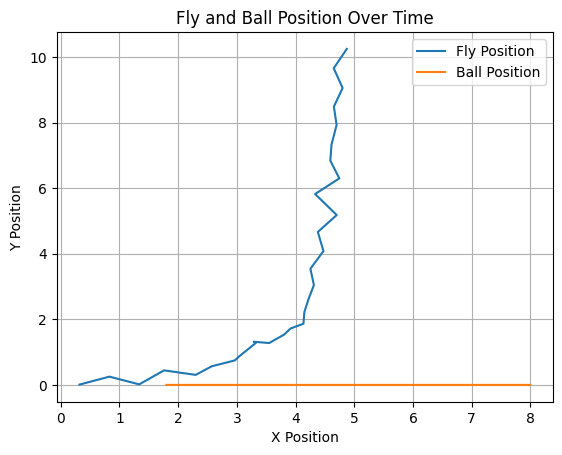

In [21]:
fly_orientation_hist = np.array(fly_orientation_hist)

fly_x = []
fly_y = []


ball_x = []
ball_y = []

for i in range(len(arena.ball_positions)):
    ball_x.append(arena.ball_positions[i][0])
    ball_y.append(arena.ball_positions[i][1])

for i in range(len(fly_orientation_hist)):
    fly_x.append(fly_orientation_hist[i][0])
    fly_y.append(fly_orientation_hist[i][1])



#Plotting both fly and ball positions
plt.plot(fly_x, fly_y, label='Fly Position')
plt.plot(ball_x, ball_y, label='Ball Position')

plt.title('Fly and Ball Position Over Time')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

[0.00416089 0.00416089 0.00138696 0.00693481 0.         0.00832178
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


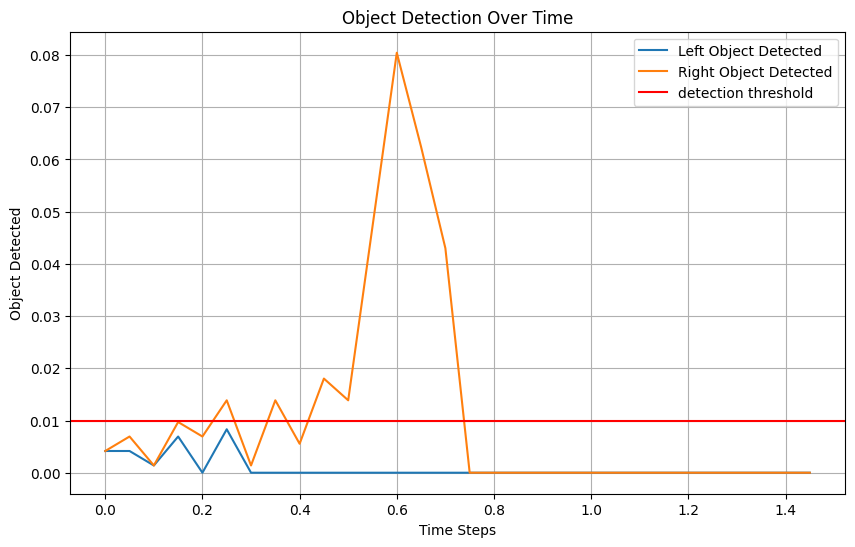

In [32]:

left_found_hist = np.array(left_found_hist)
right_found_hist = np.array(right_found_hist)
print(left_found_hist)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(times, left_found_hist, label='Left Object Detected')
plt.plot(times, right_found_hist, label='Right Object Detected')
plt.axhline(y=0.01, color='r', linestyle='-', label= 'detection threshold')
#plt.plot(times, fly_x, label='fly position' )
plt.title('Object Detection Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Object Detected')
plt.legend()
plt.grid(True)
plt.show()

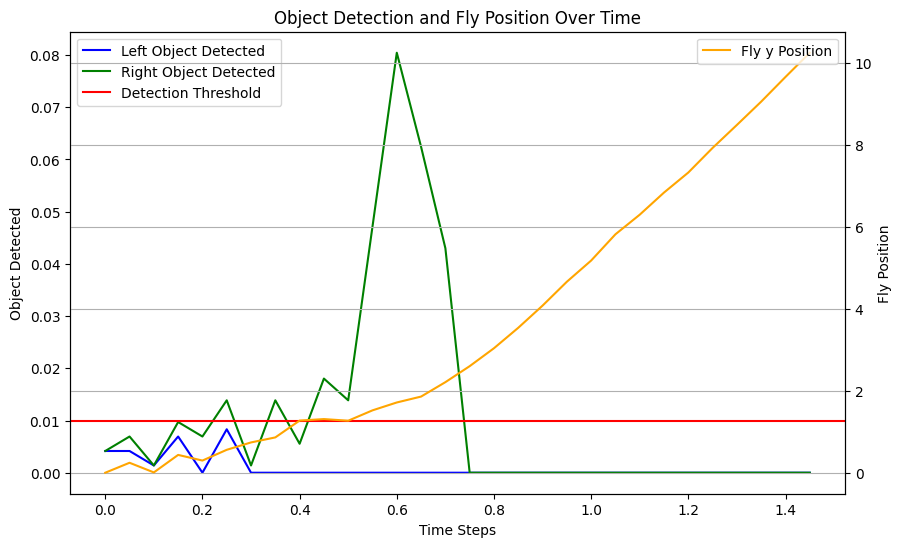

In [35]:
# Convert the lists to numpy arrays
left_found_hist = np.array(left_found_hist)
right_found_hist = np.array(right_found_hist)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot left and right object detection
ax1.plot(times, left_found_hist, label='Left Object Detected', color='blue')
ax1.plot(times, right_found_hist, label='Right Object Detected', color='green')

# Plot the detection threshold
ax1.axhline(y=0.01, color='r', linestyle='-', label='Detection Threshold')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Object Detected')
ax1.legend(loc='upper left')

# Create a secondary y-axis for fly position
ax2 = ax1.twinx()
ax2.plot(times, fly_y, label='Fly y Position', color='orange')
ax2.set_ylabel('Fly Position')
ax2.legend(loc='upper right')

plt.title('Object Detection and Fly Position Over Time')
plt.grid(True)
plt.show()
